**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import re
import gzip
import numpy as np
from numpy import random as rng

## загружаем текст 

In [4]:
with gzip.open('../data/text/lobas-taxisty.txt.gz','rt') as f: 
    text = f.read()[654:]  # ...и выкидываем заголовок
print('символов:%i\n'%(len(text)))
print(text[:327].strip())

символов:601090

Вы прилетели в Нью-Йорк и остановились в одном из отелей, глядящих окнами на Центральный парк. Наутро по приезде вы вышли из отеля, вдохнули полной грудью очищенный зеленью парка воздух и, взглянув на часы, - пора было начинать хлопотливый день, - направились к первому из таксомоторов, выстроившихся вереницей у подъезда.


## выполняем токенизацию

In [2]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

nltk version: 3.6.7


In [5]:
from random import sample
from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set() # set(nltk_stopwords.words('russian')) 

text = [ 
    [ 
     t.lower() 
     for t in nltk_tokenize_word(s) 
     if re.match(r'[а-я -]+',t.lower()) and len(t)>1 
#      if not( (t.lower() in stopwords) or (len(t)<3) ) 
    ] # разбиваем предложения на слова
    for s in nltk_sentence_split(text) # режем текст на отдельные предложения
]

print('предложений: %i\n'%(len(text)))

sample(text,5)

предложений: 6627



[['полисменом'],
 ['спросил',
  'шмуэля',
  'приглашая',
  'его',
  'сторонку',
  'чтобы',
  'нашему',
  'разговору',
  'не',
  'помешали',
  'трепачи-кэбби'],
 ['пять', 'минут', 'десять', 'такси', 'все', 'мчатся', 'мчатся', 'мимо'],
 ['слушай', 'ты', 'меня', 'не', 'один'],
 ['он', 'рентует', 'сказал', 'ежик']]

In [6]:
# заменяем слова в тексте их номерами в словаре
words = sorted(set(sum(text,[]))) # словарь из текста
vocab =  { w:i for i,w in enumerate(words) }

In [7]:
del words

In [8]:
n_words = len(vocab) # количество слов в словаре
print( "размер словаря: %i слов" % n_words )

размер словаря: 22195 слов


## собираем контексты

In [9]:
# from nltk.util import bigrams
from nltk.util import ngrams as nltk_ngrams

# вынимаем все n-gram из текста
ngram_len = 5

text_ngrams = [ 
    ngram 
    for s in text if len(s)>ngram_len
    for ngram in nltk_ngrams(s,ngram_len) 
]
print('количество n-gram: %i'%(len(set(text_ngrams))))
sample(text_ngrams,5)

количество n-gram: 54447


[('кожей', 'опасной', 'для', 'кэбби', 'поездки'),
 ('по', 'второму', 'возьмись', 'обеими', 'руками'),
 ('перекрестке', 'мы', 'остались', 'полицейским', 'вдвоем'),
 ('ответе', 'он', 'не', 'употребил', 'ни'),
 ('то', 'рекламных', 'роликах', 'который', 'тех')]

In [10]:
text_ngrams = sample(text_ngrams,1_000) # сокращаем учебный набор для ускорения процесса

### кодируем слова

In [11]:
T = np.array([ [ vocab[w] for w in ngrams ] for ngrams in text_ngrams ]) # кодируем слова

wn = ngram_len//2

W = T[:,wn] # коды слов
C = np.delete(T,wn,axis=1) # коды слов контекста

assert len(C) == len(W)

C.shape, W.shape

((1000, 4), (1000,))

In [12]:
del text_ngrams
del text
del T

In [13]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)

Wbin = np.vstack([ E[c] for c in W ])
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 

Cbin.shape, Wbin.shape

((1000, 4, 22195), (1000, 22195))

In [14]:
del W
del C

## строим модель Skip-Gram

In [27]:
# будем по контексту предсказывать слово

In [15]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [16]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [17]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [18]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

In [19]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

### обучаем модель

In [20]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = rng.normal(scale=.01,size=(n,k))
Vo = rng.normal(scale=.01,size=(k,n))

In [21]:
%%time

a = .91 # скорость обучения

er = [1e10]

n_steps = 100

for i in range(n_steps):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

1 10.007608172486618
2 10.003057910201477
3 9.994591355837711
4 9.979137914476407
5 9.954991928803315
6 9.921173659905861
7 9.877113710278605
8 9.822454168474657
9 9.75695705126269
10 9.680465467676257
11 9.592903883462656
12 9.494354634505987
13 9.385383584183709
14 9.268018691458188
15 9.148588774357972
16 9.032865907036221
17 8.912279443581356
18 8.790837364620847
19 8.662486816683831
20 8.531249505256403
21 8.394591550540333
22 8.25485777356277
23 8.110755746287388
24 7.963520008517788
25 7.812428541030236
26 7.658189512944098
27 7.500839713327542
28 7.341058683010376
29 7.178955031246639
30 7.014658917330326
31 6.848205608345062
32 6.67987905606326
33 6.510042332434998
34 6.339116560253408
35 6.167483772395991
36 5.995487606590595
37 5.823382654103596
38 5.6513093224495
39 5.479310723117533
40 5.307404072732535
41 5.135648770699531
42 4.964184173139797
43 4.793222300066258
44 4.6230066647159695
45 4.453753002737789
46 4.285594042861668
47 4.118546615759442
48 3.9525071946642383
49

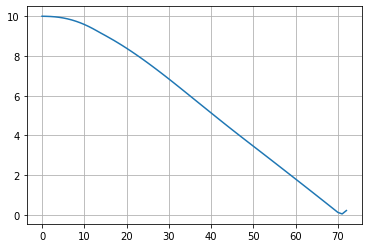

In [22]:
from matplotlib import pyplot as plt

er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

## оцениваем результат

In [23]:
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [25]:
from numpy import random as rng

In [26]:
vocab_ = { v:k for k,v in vocab.items() } # нумеруем слов в словаре

nn = rng.permutation(len(vocab))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab_[i] : [ vocab_[j] for j in  R[i,1:5]  ] for i in nn }

{'отправились': ['сын', 'фильмах', 'дерзил', 'отмазал'],
 'упадет': ['пропусти', 'нежное', 'тормознуть', 'направления'],
 'творение': ['шпаргалка', 'сигналит', 'убирала', 'пирамиду'],
 'погас': ['свежевымытый', 'водится', 'несравненно', 'полюбопытствовал'],
 'высунулась': ['прятавшегося', 'вставил', 'операцию', 'данным'],
 'торжественность': ['выгодная', 'ресторанчики', 'обочине', 'пятую'],
 'лимон': ['складу', 'напомнила', 'намучался', 'описывая'],
 'снизил': ['ручкой', 'сыном', 'наркотики', 'зависимости'],
 'стоила': ['навес', 'откликнулась', 'группе', 'итальянец'],
 'бампером': ['мальчишке', 'невыразительное', 'карьера', 'родителей'],
 'напоминал': ['орды', 'гаражной', 'установки', 'еврейская'],
 'наезженные': ['рисует', 'режиссером', 'новеллы', 'подготовил'],
 'выдохнул': ['стелился', 'помимо', 'сушиться', 'понимая'],
 'ла-гвардейцев': ['стране', 'кофты', 'пророчествовал', 'тихой'],
 'стойте': ['колесико', 'ламп', 'видимым', 'старичок'],
 'бродвеем': ['царапающий', 'свежевымытый', 